# 01. Setup

In [50]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import calendar
import seaborn as sns

In [51]:
# setting configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [52]:
# linking google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 02. Importing Data

The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated data collection, analysis, and crisis mapping project. Their free tier provides access to the last 3 years of data, which is what will be explored in this notebook. This analysis will focus purely on South Africa.

In [53]:
# importing ACLED data
acled_df = pd.read_csv('/content/drive/MyDrive/acled_21_23.csv')
acled_df.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,civilian_targeting,iso,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,SAF20349,31 December 2023,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Africa),NaN,3,Civilians (South Africa),Ndebele Ethnic Group (South Africa),7,37,Civilian targeting,710,Southern Africa,South Africa,Gauteng,City of Tshwane,City of Tshwane,Pretoria,-25.7449,28.1878,2,Sowetan (South Africa),National,"On 31 December 2023, three armed suspects shot...",2,NaN,1704766941
1,SAF20350,31 December 2023,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Africa),NaN,3,Civilians (South Africa),NaN,7,37,Civilian targeting,710,Southern Africa,South Africa,Western Cape,City of Cape Town,City of Cape Town,Cape Town - Philippi,-34.0167,18.5500,1,IOL,National,"On 31 December 2023, an unidentified gunman sh...",1,NaN,1704766941
2,SAF20348,29 December 2023,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (South Africa),Anglican Christian Group (South Africa); Healt...,6,NaN,NaN,0,60,NaN,710,Southern Africa,South Africa,Western Cape,City of Cape Town,City of Cape Town,Cape Town - Sea Point,-33.9186,18.3897,1,IOL,National,"On 29 December 2023, over 300 health workers, ...",0,crowd size=over 300,1704766941
3,SAF20345,28 December 2023,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Africa),NaN,3,Civilians (South Africa),Women (South Africa),7,37,Civilian targeting,710,Southern Africa,South Africa,Eastern Cape,Amathole,Mbhashe,Idutywa,-32.0962,28.3049,1,Daily Dispatch,Subnational,"On 28 December 2023, an unknown gunman shot an...",1,women targeted: relatives of targeted groups o...,1704766941
4,SAF20346,28 December 2023,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (South Africa),NaN,6,NaN,NaN,0,60,NaN,710,Southern Africa,South Africa,Gauteng,City of Johannesburg,City of Johannesburg,Johannesburg - Randburg,-26.0941,28.0012,1,Daily Sun (South Africa),National,"On 28 December 2023, Diepsloot residents gathe...",0,crowd size=no report,1704766941


In [54]:
# checking shape of acled_df
acled_df.shape

(6124, 31)

In [55]:
# check data types of colums in acled_df
acled_df.dtypes

event_id_cnty          object
event_date             object
year                    int64
time_precision          int64
disorder_type          object
event_type             object
sub_event_type         object
actor1                 object
assoc_actor_1          object
inter1                  int64
actor2                 object
assoc_actor_2          object
inter2                  int64
interaction             int64
civilian_targeting     object
iso                     int64
region                 object
country                object
admin1                 object
admin2                 object
admin3                 object
location               object
latitude              float64
longitude             float64
geo_precision           int64
source                 object
source_scale           object
notes                  object
fatalities              int64
tags                   object
timestamp               int64
dtype: object

Importing the data into Pandas we get the above data frame which consists of 6124 rows, implying that there were **6124 political disorder events reported in South Africa over the last 3 years**. The 31 columns provide more information on each political disorder event such as location, disorder type, and parties involved. You can find more information on what each column represents in the [ACLED codebook](https://https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2023/06/ACLED_Codebook_2023.pdf).

Reasons for political disorder can be complex and multifaceted, often involving a combination of social, economic, and political factors all of which are more prevalent in areas with larger populations, so lets add some population figures to this dataset for the local municipalities.

In [56]:
# importing population data
pop_df = pd.read_csv('/content/drive/MyDrive/SA/22_mun_pop_census.csv')
pop_df.head()

,municipality,population_2022
0,Alfred Nzo,936 462
1,Amajuba,687 408
2,Amathole,871 601
3,Bojanala,1 624 144
4,Buffalo City,975 255


In [57]:
# checking shape of pop_df
pop_df.shape

(52, 2)

In [58]:
# check data types of columns in pop_df
pop_df.dtypes

municipality       object
population_2022    object
dtype: object

In [59]:
# convert 'population_2022' to int64
pop_df['population_2022'] = pop_df['population_2022'].str.replace(' ', '').astype('int64')

In [60]:
# check if unique values in the acled_df are the same as in the pop_df
unique_values_match = set(acled_df['admin2'].unique()) == set(pop_df['municipality'].unique())
print("Unique values match:", unique_values_match)

Unique values match: True


In [61]:
# perform the merge
merged_df = pd.merge(acled_df, pop_df, how='left', left_on='admin2', right_on='municipality')

# drop the 'municipality' column from the merged_df
merged_df.drop('municipality', axis=1, inplace=True)

In [62]:
merged_df.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,civilian_targeting,iso,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp,population_2022
0,SAF20349,31 December 2023,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Africa),NaN,3,Civilians (South Africa),Ndebele Ethnic Group (South Africa),7,37,Civilian targeting,710,Southern Africa,South Africa,Gauteng,City of Tshwane,City of Tshwane,Pretoria,-25.7449,28.1878,2,Sowetan (South Africa),National,"On 31 December 2023, three armed suspects shot...",2,NaN,1704766941,4040315
1,SAF20350,31 December 2023,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Africa),NaN,3,Civilians (South Africa),NaN,7,37,Civilian targeting,710,Southern Africa,South Africa,Western Cape,City of Cape Town,City of Cape Town,Cape Town - Philippi,-34.0167,18.5500,1,IOL,National,"On 31 December 2023, an unidentified gunman sh...",1,NaN,1704766941,4772846
2,SAF20348,29 December 2023,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (South Africa),Anglican Christian Group (South Africa); Healt...,6,NaN,NaN,0,60,NaN,710,Southern Africa,South Africa,Western Cape,City of Cape Town,City of Cape Town,Cape Town - Sea Point,-33.9186,18.3897,1,IOL,National,"On 29 December 2023, over 300 health workers, ...",0,crowd size=over 300,1704766941,4772846
3,SAF20345,28 December 2023,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Africa),NaN,3,Civilians (South Africa),Women (South Africa),7,37,Civilian targeting,710,Southern Africa,South Africa,Eastern Cape,Amathole,Mbhashe,Idutywa,-32.0962,28.3049,1,Daily Dispatch,Subnational,"On 28 December 2023, an unknown gunman shot an...",1,women targeted: relatives of targeted groups o...,1704766941,871601
4,SAF20346,28 December 2023,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (South Africa),NaN,6,NaN,NaN,0,60,NaN,710,Southern Africa,South Africa,Gauteng,City of Johannesburg,City of Johannesburg,Johannesburg - Randburg,-26.0941,28.0012,1,Daily Sun (South Africa),National,"On 28 December 2023, Diepsloot residents gathe...",0,crowd size=no report,1704766941,4803262


In [63]:
# checking shape of merged_df
merged_df.shape

(6124, 32)

In [64]:
# saving amended df
merged_df.to_csv("/content/drive/MyDrive/acled_and_pop.csv", index=False)

# 03. Exploratory Data Analysis

## A. Top Sub-Event Types in South Africa

Let's take a look at the different types of politcal disorder events that occured in South Afria during 2021-2023.

In [65]:
# get unique values for disorder_type, event_type, and sub_event_type
unique_disorder_types = acled_df['disorder_type'].unique()
unique_event_types = acled_df['event_type'].unique()
unique_sub_event_types = acled_df['sub_event_type'].unique()

# display the unique values
print("Unique Disorder Types:", unique_disorder_types)
print("Unique Event Types:", unique_event_types)
print("Unique Sub Event Types:", unique_sub_event_types)

Unique Disorder Types: ['Political violence' 'Demonstrations' 'Strategic developments'
 'Political violence; Demonstrations']
Unique Event Types: ['Violence against civilians' 'Protests' 'Riots' 'Strategic developments'
 'Battles']
Unique Sub Event Types: ['Attack' 'Peaceful protest' 'Violent demonstration' 'Mob violence'
 'Looting/property destruction' 'Protest with intervention'
 'Sexual violence' 'Other' 'Armed clash' 'Arrests'
 'Excessive force against protesters' 'Abduction/forced disappearance'
 'Agreement' 'Disrupted weapons use']


In [66]:
# group by 'sub_event_type' and count the number of occurrences
grouped_data = acled_df.groupby('sub_event_type')['event_id_cnty'].count().reset_index()

# rename the count column
grouped_data.rename(columns={'event_id_cnty': 'event_count'}, inplace=True)

# calculate the percentage column
grouped_data['percentage'] = (grouped_data['event_count'] / grouped_data['event_count'].sum())

# sort the data by 'event_count' in descending order
grouped_data = grouped_data.sort_values(by='event_count', ascending=True).reset_index(drop=True)

# display the result
grouped_data

,sub_event_type,event_count,percentage
0,Disrupted weapons use,1,0.000163
1,Agreement,2,0.000327
2,Other,4,0.000653
3,Arrests,7,0.001143
4,Excessive force against protesters,11,0.001796
5,Sexual violence,12,0.001960
6,Abduction/forced disappearance,17,0.002776
7,Armed clash,19,0.003103
8,Looting/property destruction,50,0.008165
9,Protest with intervention,128,0.020901


Between 2021 and 2023 in Sout Africa, 'peaceful protests' constituted 54% of political disorder events, followed by 'violent demonstrations' at 23% and 'attacks' at 12%.

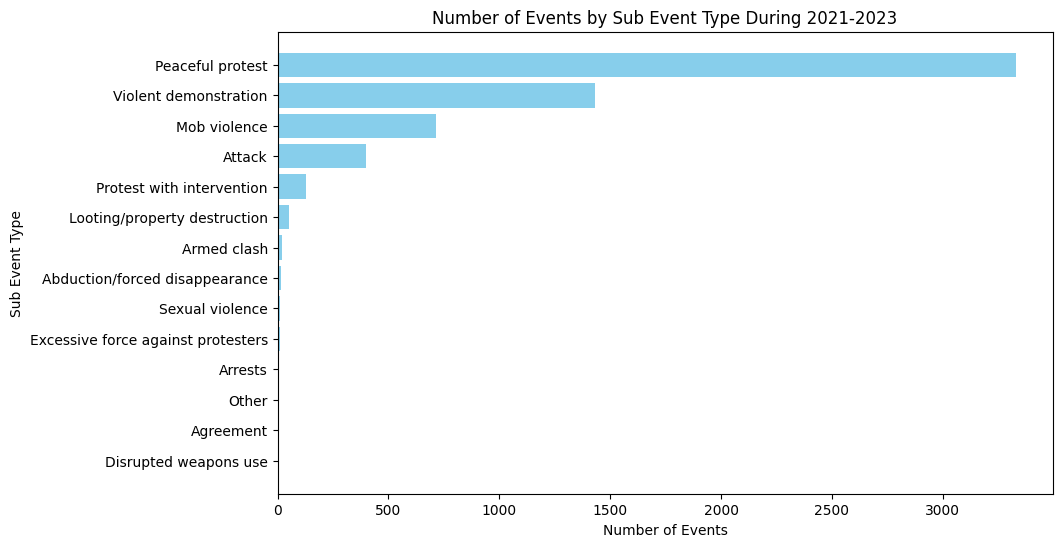

In [67]:
# plotting the horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(grouped_data['sub_event_type'], grouped_data['event_count'], color='skyblue')

# adding labels and title
plt.xlabel('Number of Events')
plt.ylabel('Sub Event Type')
plt.title('Number of Events by Sub Event Type During 2021-2023')

# show the plot
plt.show()

## B. Actor Profile

The assoc_actor_1 column provides us with more context around who is primarily involved in each event and identifies 'Actor 1'. Let's take a closer look at who is involved with a deeper dive on the political parties involved.

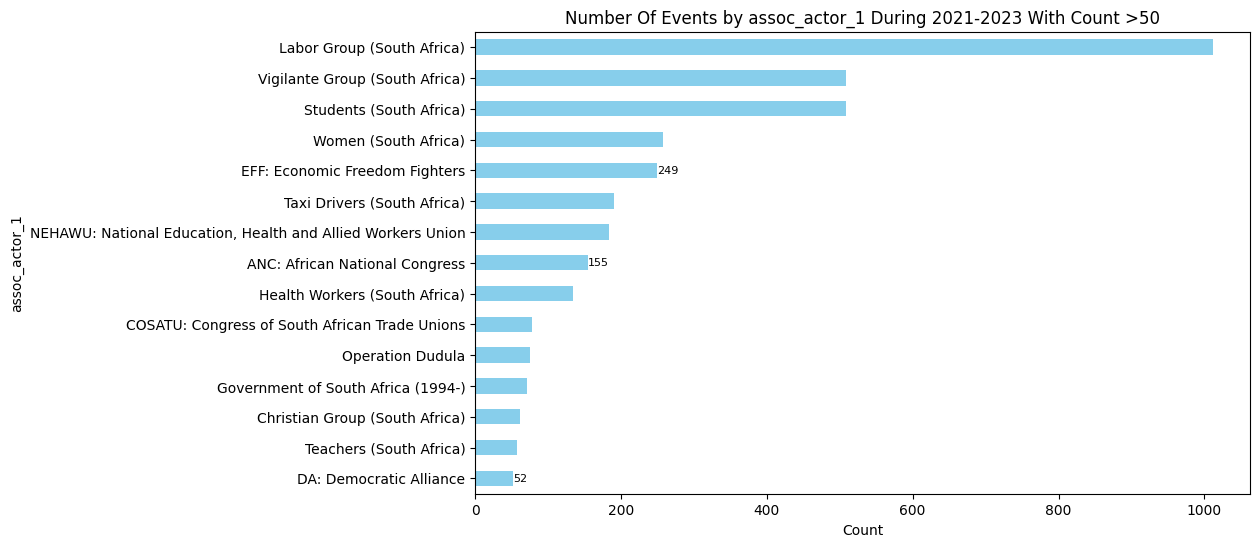

In [68]:
# convert 'event_date' to datetime type
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])

# split and clean the 'assoc_actor_1' values
assoc_actors_split_unfilt = merged_df['assoc_actor_1'].str.split(';').explode().str.strip()

# count and combine the values after the split
combined_assoc_actor_counts_unfilt = assoc_actors_split_unfilt.value_counts()

# drop values with count less than 2
combined_assoc_actor_counts_unfilt = combined_assoc_actor_counts_unfilt[combined_assoc_actor_counts_unfilt >= 50]

# plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
combined_assoc_actor_counts_unfilt.sort_values().plot(kind='barh', color='skyblue')
plt.title('Number Of Events by assoc_actor_1 During 2021-2023 With Count >50')
plt.xlabel('Count')
plt.ylabel('assoc_actor_1')
# adding annotations for specific values
for index, value in enumerate(combined_assoc_actor_counts_unfilt):
    if combined_assoc_actor_counts_unfilt.index[index] in ['ANC: African National Congress', 'DA: Democratic Alliance', 'EFF: Economic Freedom Fighters']:
        plt.text(value, len(combined_assoc_actor_counts_unfilt) - index - 1, str(value), ha='left', va='center', fontsize=8)
plt.show()

<Figure size 1000x800 with 0 Axes>

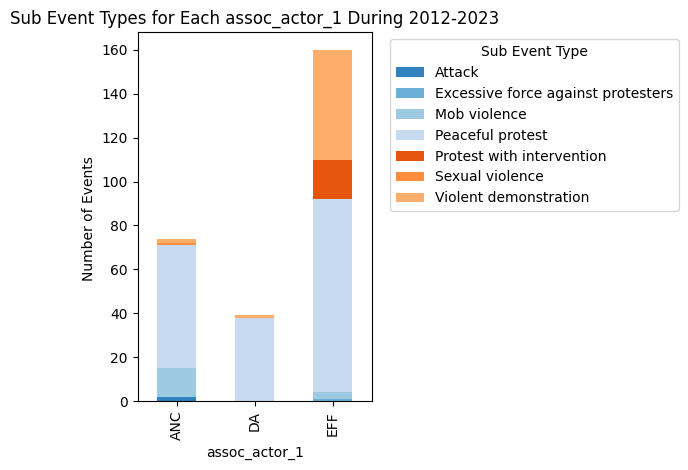

In [69]:
# filter DataFrame to include only desired assoc_actor_1 values
filtered_df = merged_df[merged_df['assoc_actor_1'].isin(["ANC: African National Congress", "DA: Democratic Alliance", "EFF: Economic Freedom Fighters"])]

# group by assoc_actor_1 and sub_event_type, count occurrences, and select top sub_event_type for each assoc_actor_1
top_sub_event_types = filtered_df.groupby(['assoc_actor_1', 'sub_event_type'])['event_id_cnty'].count().reset_index()
top_sub_event_types = top_sub_event_types.pivot_table(index='assoc_actor_1', columns='sub_event_type', values='event_id_cnty', aggfunc='max')

# change assoc_actor_1 names
top_sub_event_types.index = ['ANC', 'DA', 'EFF']

# plotting the stacked vertical bar chart
plt.figure(figsize=(10, 8))
top_sub_event_types.plot(kind='bar', stacked=True, color=plt.cm.tab20c.colors)
plt.title('Sub Event Types for Each assoc_actor_1 During 2012-2023')
plt.xlabel('assoc_actor_1')
plt.ylabel('Number of Events ')
plt.legend(title='Sub Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

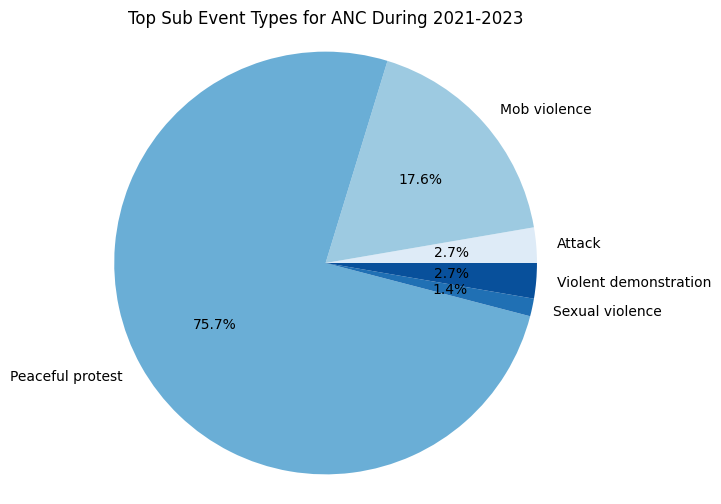

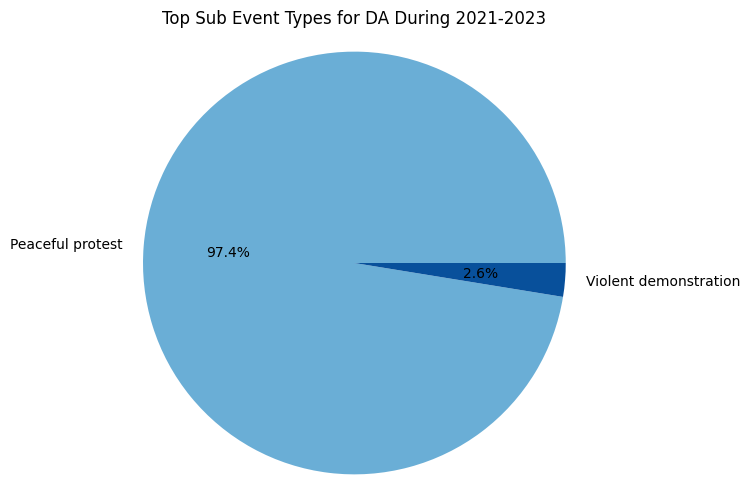

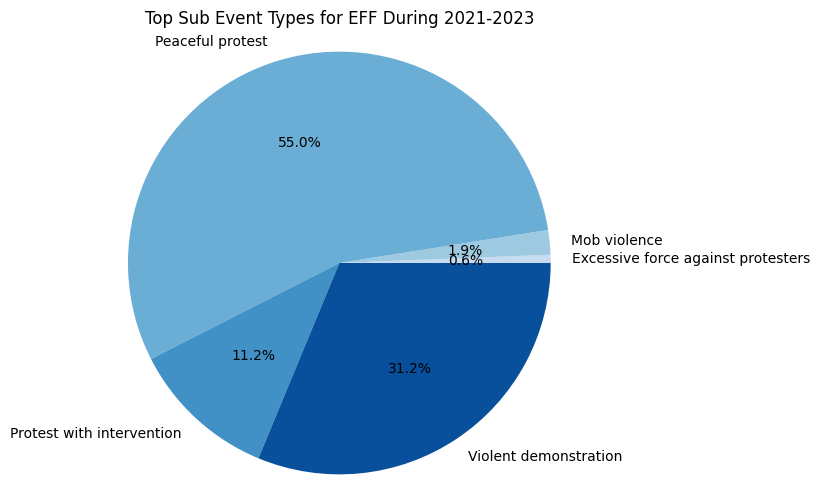

In [70]:
# filter DataFrame to include only desired assoc_actor_1 values
filtered_df = merged_df[merged_df['assoc_actor_1'].isin(["ANC: African National Congress", "DA: Democratic Alliance", "EFF: Economic Freedom Fighters"])]

# group by assoc_actor_1 and sub_event_type, count occurrences, and select top sub_event_type for each assoc_actor_1
top_sub_event_types = filtered_df.groupby(['assoc_actor_1', 'sub_event_type'])['event_id_cnty'].count().reset_index()
top_sub_event_types = top_sub_event_types.pivot_table(index='assoc_actor_1', columns='sub_event_type', values='event_id_cnty', aggfunc='max')

# change assoc_actor_1 names
top_sub_event_types.index = ['ANC', 'DA', 'EFF']

# get unique sub-event types from the dataset
unique_sub_event_types = top_sub_event_types.columns

# generate a color palette for sub-event types
unique_sub_event_types = top_sub_event_types.columns
colors = sns.color_palette('Blues', n_colors=len(unique_sub_event_types))

# create a dictionary mapping each sub-event type to a color
color_dict = dict(zip(unique_sub_event_types, colors))

# plotting pie charts
for actor in top_sub_event_types.index:
    plt.figure(figsize=(6, 6))
    data = top_sub_event_types.loc[actor].dropna()  # drop NaN values
    # use the color dictionary to assign colors
    pie_colors = [color_dict[sub_event_type] for sub_event_type in data.index]
    plt.pie(data, labels=data.index, autopct='%1.1f%%', colors=pie_colors)
    plt.title(f'Top Sub Event Types for {actor} During 2021-2023')
    plt.axis('equal')  # equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

The composition of sub-event types differs significantly among various political parties. The DA predominantly participates in peaceful political disorder events, while the ANC engages in roughly 75% peaceful events. In contrast, approximately 45% of the events involving the EFF turn violent.

## C. Temporal Trends in Political Disorder Events

Let's take a look at how the number of pilitical disorder events compare across the years.

<Figure size 1200x600 with 0 Axes>

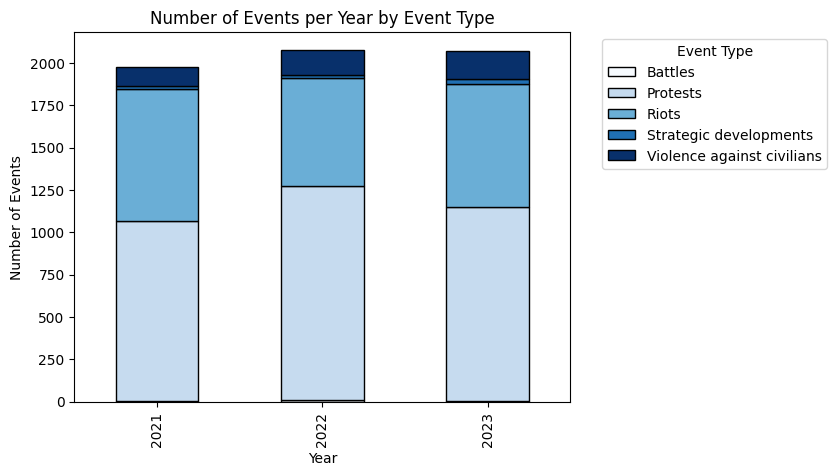

In [71]:
# convert 'event_date' to datetime type
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])

# extract the year from the 'event_date' column
merged_df['year'] = merged_df['event_date'].dt.year

# create a pivot table to count events by year and event_type
events_by_type = pd.pivot_table(merged_df, values='event_id_cnty', index='year', columns='event_type', aggfunc='count', fill_value=0)

# plot the stacked bar chart
plt.figure(figsize=(12, 6))
events_by_type.plot(kind='bar', stacked=True, colormap='Blues', edgecolor='black')
plt.title('Number of Events per Year by Event Type')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Let's take a look at what months political disorder events tend to take place.

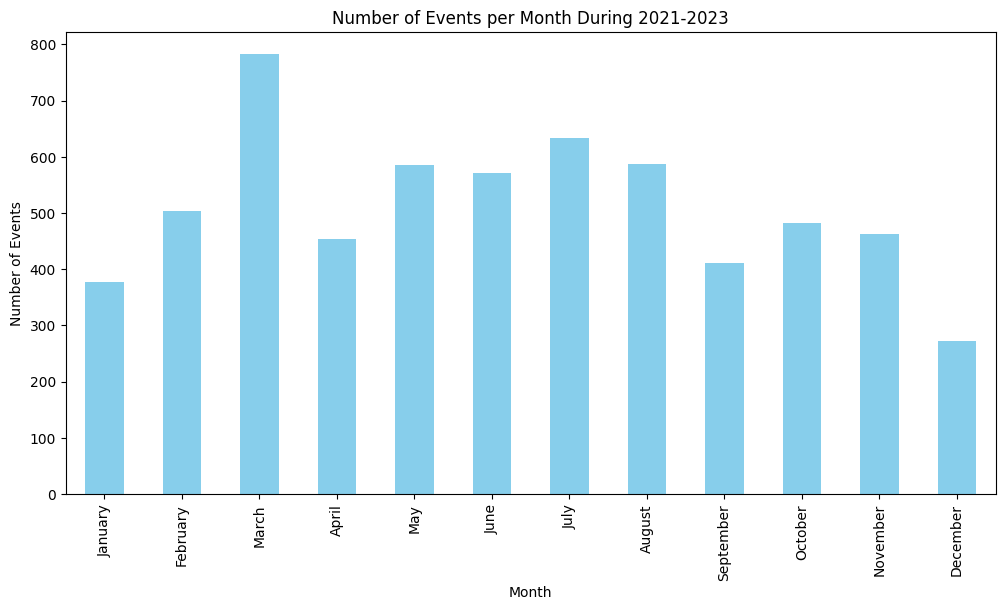

In [72]:
# extract the month from the 'event_date' column
merged_df['month'] = merged_df['event_date'].dt.month_name()

# group by month and count the number of events
events_per_month = merged_df.groupby('month').size()

# plot the bar chart
plt.figure(figsize=(12, 6))
events_per_month = events_per_month.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
events_per_month.plot(kind='bar', color='skyblue')
plt.title('Number of Events per Month During 2021-2023')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.show()

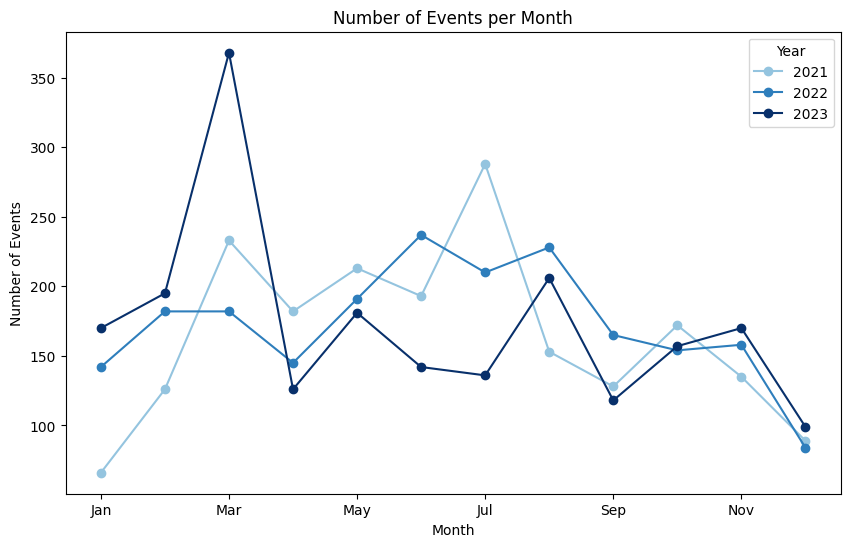

In [73]:
from matplotlib.colors import LinearSegmentedColormap

# convert 'event_date' column to datetime type
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])

# create a new column for the year
merged_df['year'] = merged_df['event_date'].dt.year

# create a new column for the month
merged_df['month'] = merged_df['event_date'].dt.month

# group by year and month, and count the number of events
grouped_df = merged_df.groupby(['year', 'month']).size().reset_index(name='event_count')

# pivot the table to have separate columns for each year
pivot_df = grouped_df.pivot(index='month', columns='year', values='event_count')

# rename the month numbers with their names
pivot_df.index = pivot_df.index.map(lambda x: calendar.month_abbr[x])

# Define a custom colormap with only darker shades of 'Blues'
blues_colors = plt.cm.Blues(np.linspace(0.4, 1, 10))
blues_cmap = LinearSegmentedColormap.from_list('Blues_darker', blues_colors)


# plotting the line graph
plt.figure(figsize=(10, 6))
pivot_df.plot(kind='line', marker='o', linestyle='-', colormap=blues_cmap, ax=plt.gca())

# set labels and title
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.title('Number of Events per Month')

# show the legend
plt.legend(title='Year')

# show the plot
plt.show()

Looking at the monthly distribution of political disorder events there a two spikes, July 2021 and March 2023, and a notable decline in events during the festive "Dezemba" period.

Let's take a look at what caused the spikes in July 2021 and March 2023. To do this we will look at the actor1 and assoc_actor_1 columns (not all actor1 values have corresponding assoc_actor_1 values).

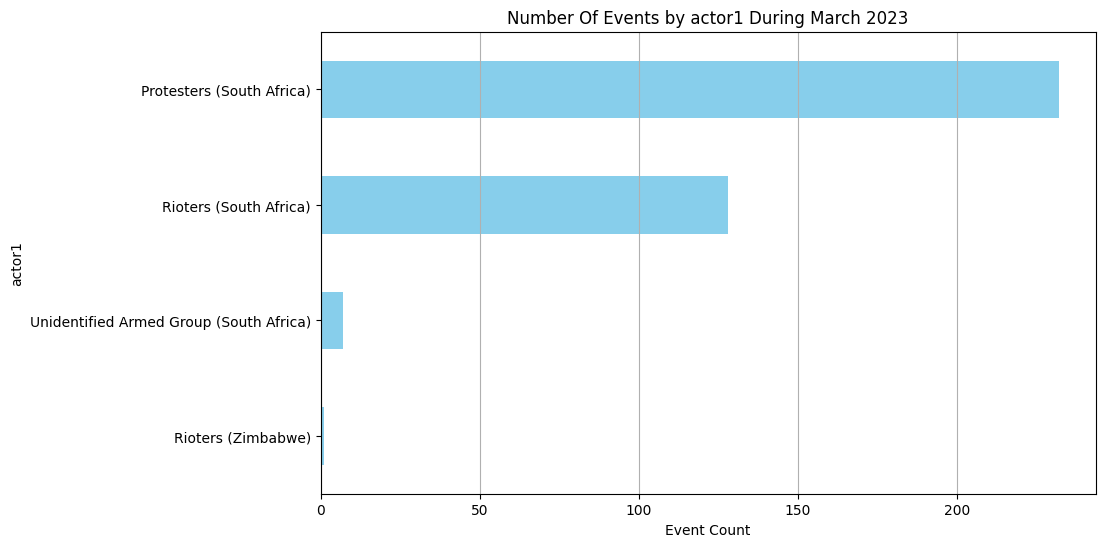

In [74]:
# filter data for March 2023
march_data_actor1 = merged_df[(merged_df['event_date'] >= '2023-03-01') & (merged_df['event_date'] <= '2023-03-31')]

# count and combine the values in the 'actor1' column
combined_actor1_counts_march = march_data_actor1['actor1'].value_counts()

# plotting the horizontal bar chart for March 2023
plt.figure(figsize=(10, 6))
combined_actor1_counts_march.sort_values().plot(kind='barh', color='skyblue')
plt.title('Number Of Events by actor1 During March 2023')
plt.xlabel('Event Count')
plt.ylabel('actor1')
plt.grid(axis='x')
plt.show()

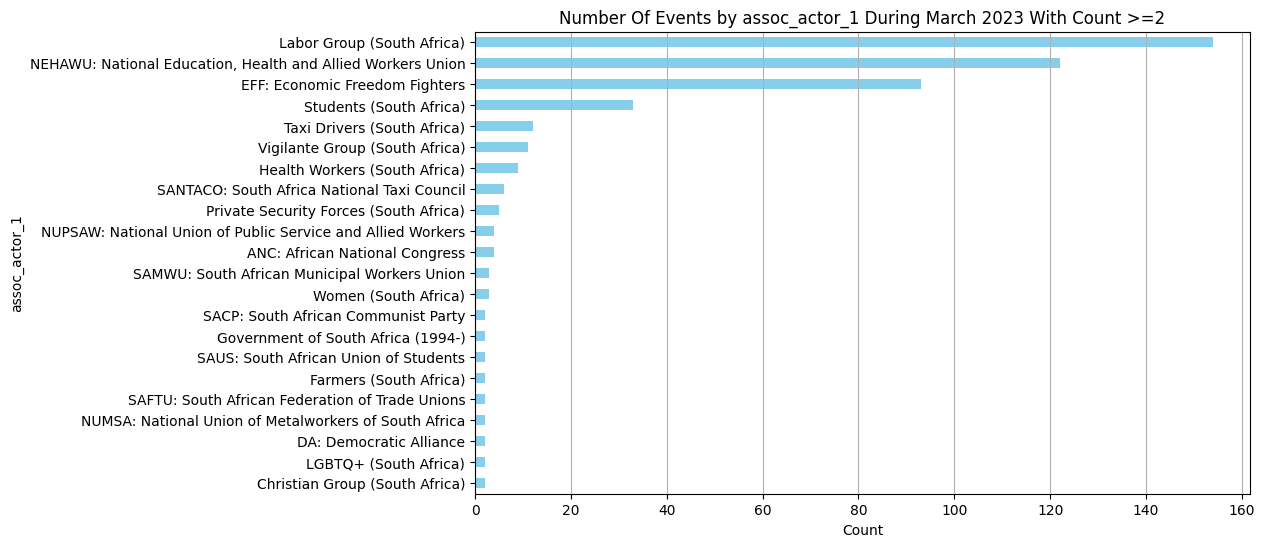

In [75]:
# filter data for March 2023
march_data = merged_df[(merged_df['event_date'] >= '2023-03-01') & (merged_df['event_date'] <= '2023-03-31')]

# split and clean the 'assoc_actor_1' values
assoc_actors_split = march_data['assoc_actor_1'].str.split(';').explode().str.strip()

# count and combine the values after the split
combined_assoc_actor_counts = assoc_actors_split.value_counts()

# drop values with count less than 2
combined_assoc_actor_counts = combined_assoc_actor_counts[combined_assoc_actor_counts >= 2]

# plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
combined_assoc_actor_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Number Of Events by assoc_actor_1 During March 2023 With Count >=2')
plt.xlabel('Count')
plt.ylabel('assoc_actor_1')
plt.grid(axis='x')
plt.show()

The March 2023 spike was caused by [NEHAWU & Labor Group protests](https://medium.com/r/?url=https%3A%2F%2Fwww.nehawu.org.za%2FNEHAWU%2520Statement%2520On%2520The%2520Public%2520Service%2520Strike%252015%2520March%25202023.html) held throughout the month as well as a [national shutdown](https://https://medium.com/r/?url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2F2023_South_African_National_Shutdown) organised by the EFF political party.

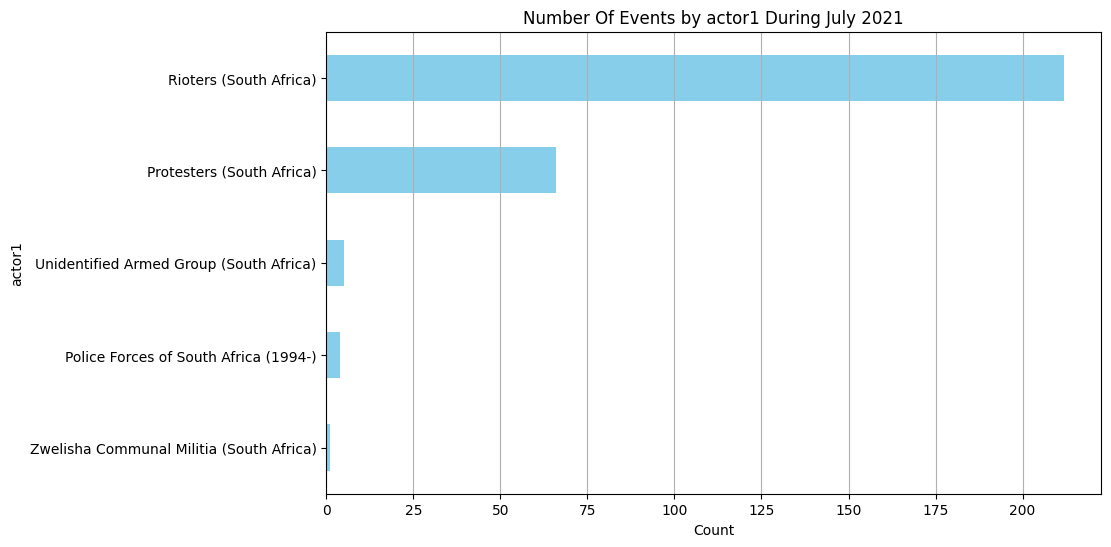

In [76]:
# filter data for July 2021
july_data_actor1 = merged_df[(merged_df['event_date'] >= '2021-07-01') & (merged_df['event_date'] <= '2021-07-31')]

# count and combine the values in the 'actor1' column
combined_actor1_counts_july = july_data_actor1['actor1'].value_counts()

# plotting the horizontal bar chart for July 2021
plt.figure(figsize=(10, 6))
combined_actor1_counts_july.sort_values().plot(kind='barh', color='skyblue')
plt.title('Number Of Events by actor1 During July 2021')
plt.xlabel('Count')
plt.ylabel('actor1')
plt.grid(axis='x')
plt.show()

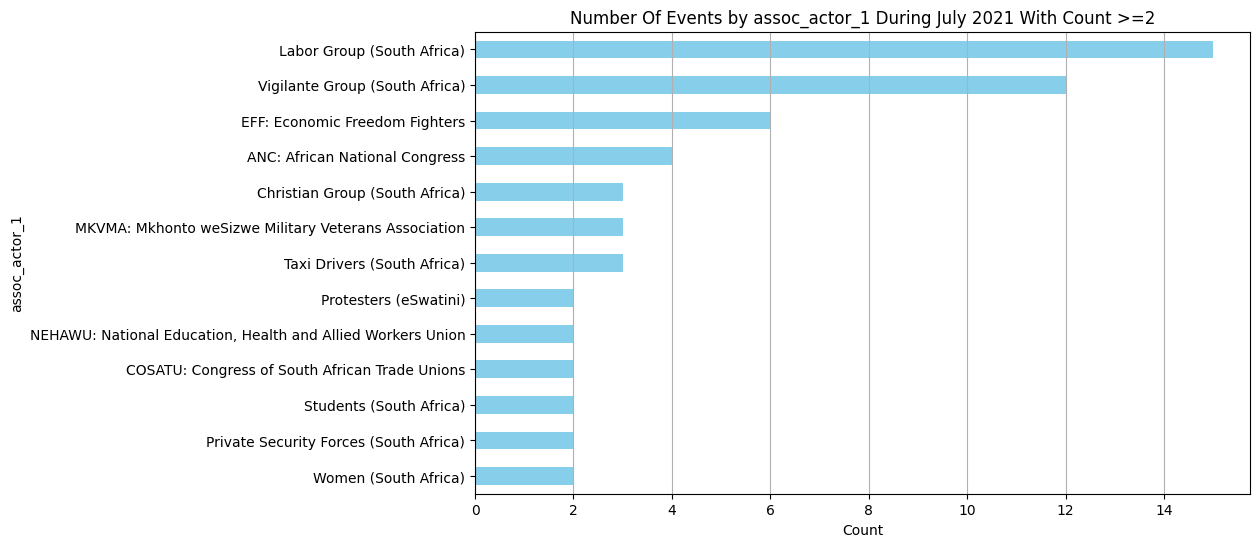

In [77]:
# convert 'event_date' to datetime type
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])

# filter data for July 2021
july_data = merged_df[(merged_df['event_date'] >= '2021-07-01') & (merged_df['event_date'] <= '2021-07-31')]

# split and clean the 'assoc_actor_1' values
assoc_actors_split_july = july_data['assoc_actor_1'].str.split(';').explode().str.strip()

# count and combine the values after the split
combined_assoc_actor_counts_july = assoc_actors_split_july.value_counts()

# drop values with count less than 2
combined_assoc_actor_counts_july = combined_assoc_actor_counts_july[combined_assoc_actor_counts_july >= 2]

# plotting the horizontal bar chart for July 2021
plt.figure(figsize=(10, 6))
combined_assoc_actor_counts_july.sort_values().plot(kind='barh', color='skyblue')
plt.title('Number Of Events by assoc_actor_1 During July 2021 With Count >=2')
plt.xlabel('Count')
plt.ylabel('assoc_actor_1')
plt.grid(axis='x')
plt.show()

The July 2021 spike was caused by the [imprisonment of former President Jacob Zuma](https://https://medium.com/r/?url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2F2021_South_African_unrest) and the subsequent unrest that occured. This is reflected by the high number of riots that occured during the month.

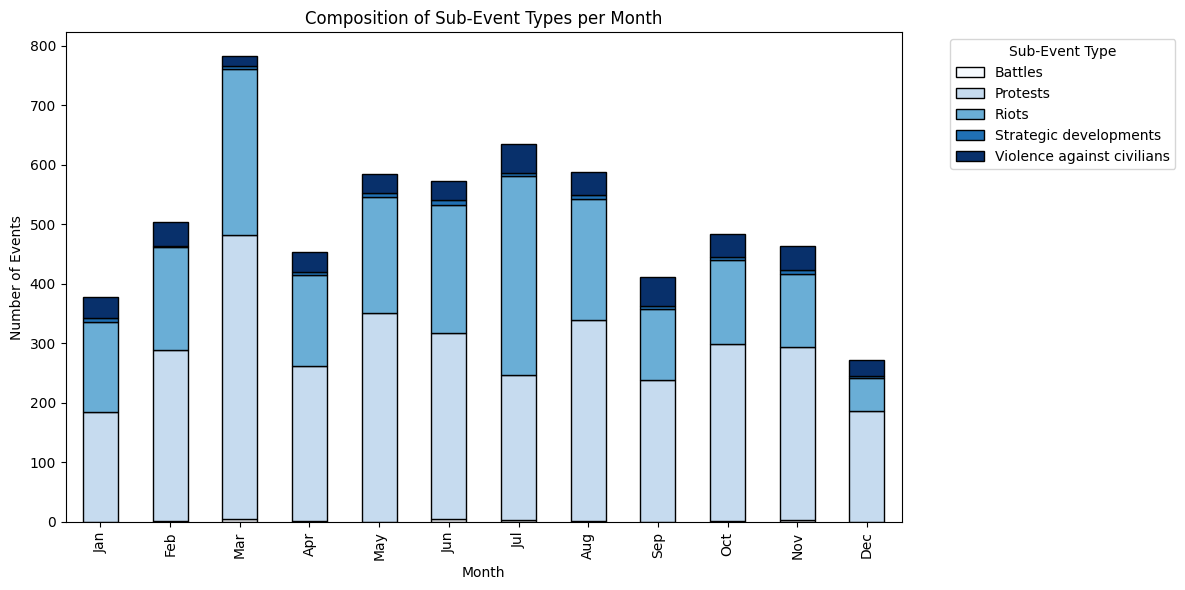

In [78]:
# group by month and sub_event_type and count occurrences
monthly_subevent_counts = merged_df.groupby(['month', 'event_type']).size().unstack(fill_value=0)

# plotting
fig, ax = plt.subplots(figsize=(12, 6))

# rename the month numbers with their names
monthly_subevent_counts.index = monthly_subevent_counts.index.map(lambda x: calendar.month_abbr[x])

# stacked bar chart
monthly_subevent_counts.plot(kind='bar', stacked=True, colormap='Blues', edgecolor='black', ax=ax)

# add labels and title
ax.set_title('Composition of Sub-Event Types per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Events')

# show legend
ax.legend(title='Sub-Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## D. Geographic Trends

Reasons for political disorder can be complex and multifaceted, often involving a combination of social, economic, and political factors all of which are more prevalent in areas with larger populations. Let's see if this is reflected in the data.

In [79]:
# group by 'admin2' and count the occurrences of 'event_id_cnty'
event_count_per_admin2 = merged_df.groupby('admin2')['event_id_cnty'].count().reset_index()

# merge the population data into the event count data
merged_data = pd.merge(event_count_per_admin2, merged_df[['admin2', 'population_2022']], on='admin2', how='left')

# calculate the correlation
correlation = merged_data['event_id_cnty'].corr(merged_data['population_2022'])

# display the result
print("Correlation between event count and population_2022:", correlation)

Correlation between event count and population_2022: 0.9140065998957506


The correlation of 0.91 indicates that there is a strong positive linear relationship between the size of the population and the number of political disorder events. Let's visualise the correlation on a scatterplot.

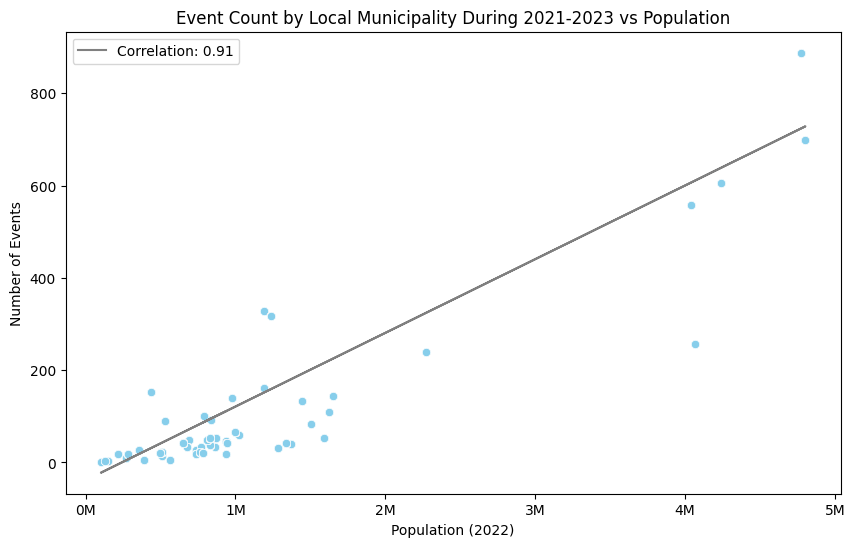

In [80]:
from matplotlib.ticker import FuncFormatter

# create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='population_2022', y='event_id_cnty', color='skyblue',data=merged_data)

# fit a linear regression line
fit = np.polyfit(merged_data['population_2022'], merged_data['event_id_cnty'], 1)
fit_fn = np.poly1d(fit)

# plot the regression line
plt.plot(merged_data['population_2022'], fit_fn(merged_data['population_2022']), color='grey', label=f'Correlation: {correlation:.2f}')

# format x-axis labels to represent millions
formatter = FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-6))
plt.gca().xaxis.set_major_formatter(formatter)

# add labels and title
plt.title('Event Count by Local Municipality During 2021-2023 vs Population')
plt.xlabel('Population (2022)')
plt.ylabel('Number of Events')

# show legend
plt.legend()

# show the plot
plt.show()

Let's now take a look at this on a chloropleth map for a better understanding of where the areas with a large number of political disorder events are located.

In [81]:
# import shape file for SA metropolitan and district municipalities
gdf = gpd.read_file('/content/drive/MyDrive/district_shape')
gdf.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,211,ZAF,South Africa,1,Eastern Cape,1,Alfred Nzo,ZA.EC.AN,0,DC44,District Municipality,District Municipality,None,None,"MULTIPOLYGON (((30.19438 -31.07847, 30.19431 -..."
1,211,ZAF,South Africa,1,Eastern Cape,2,Amathole,ZA.EC.AT,0,DC12,District Municipality,District Municipality,None,None,"MULTIPOLYGON (((27.46166 -33.28264, 27.46125 -..."
2,211,ZAF,South Africa,1,Eastern Cape,3,Buffalo City,None,0,BUF,District Municipality,District Municipality,None,None,"MULTIPOLYGON (((27.45847 -33.28153, 27.45847 -..."
3,211,ZAF,South Africa,1,Eastern Cape,4,Cacadu,ZA.EC.CC,0,DC10,District Municipality,District Municipality,None,None,"MULTIPOLYGON (((26.26375 -33.83736, 26.26375 -..."
4,211,ZAF,South Africa,1,Eastern Cape,5,Chris Hani,ZA.EC.CH,0,DC13,District Municipality,District Municipality,None,None,"POLYGON ((26.37107 -31.18372, 26.37934 -31.188..."


In [82]:
# dropping columns not needed for analysis
gdf = gdf[['NAME_2', 'geometry']]
gdf.head()

,NAME_2,geometry
0,Alfred Nzo,"MULTIPOLYGON (((30.19438 -31.07847, 30.19431 -..."
1,Amathole,"MULTIPOLYGON (((27.46166 -33.28264, 27.46125 -..."
2,Buffalo City,"MULTIPOLYGON (((27.45847 -33.28153, 27.45847 -..."
3,Cacadu,"MULTIPOLYGON (((26.26375 -33.83736, 26.26375 -..."
4,Chris Hani,"POLYGON ((26.37107 -31.18372, 26.37934 -31.188..."


In [83]:
# checking the names of municipalities to ensure they correspond with the names used in the acled data

# get unique values in the "Name_2" column of gdf
unique_values_gdf = gdf["NAME_2"].unique()

# check if values in the "admin2" column of merged_df are not in unique_values_gdf
not_present_values = merged_df[~merged_df["admin2"].isin(unique_values_gdf)]

# drop duplicates from the "admin2" column to print only unique values
unique_not_present_values = not_present_values["admin2"].drop_duplicates()

# print the unique values that are not present in both DataFrames
print(unique_not_present_values)

180    Sarah Baartman
479        Z F Mgcawu
Name: admin2, dtype: object


In [84]:
# rename specific values in admin2 column due to municipality name changes and rename NAME_2 column for merge
gdf['NAME_2'] = gdf['NAME_2'].replace({'Cacadu': 'Sarah Baartman', 'Siyanda': 'Z F Mgcawu'})
gdf = gdf.rename(columns={"NAME_2": "admin2"})

In [85]:
# group acled data by the 'admin2' column and count the number of events per):
municipality_events = merged_df.groupby('admin2')['event_id_cnty'].count().reset_index()
municipality_events.head()

,admin2,event_id_cnty
0,Alfred Nzo,19
1,Amajuba,49
2,Amathole,53
3,Bojanala,109
4,Buffalo City,140


In [86]:
# merge the two dataframes using the 'admin2' column
map = gdf.merge(municipality_events, on='admin2', how='left')

In [87]:
# checking for missing values
map['event_id_cnty'].isna().sum()

0

Ok now its time to plot the chloropleth map to visualise the dispersion of political disorder events.

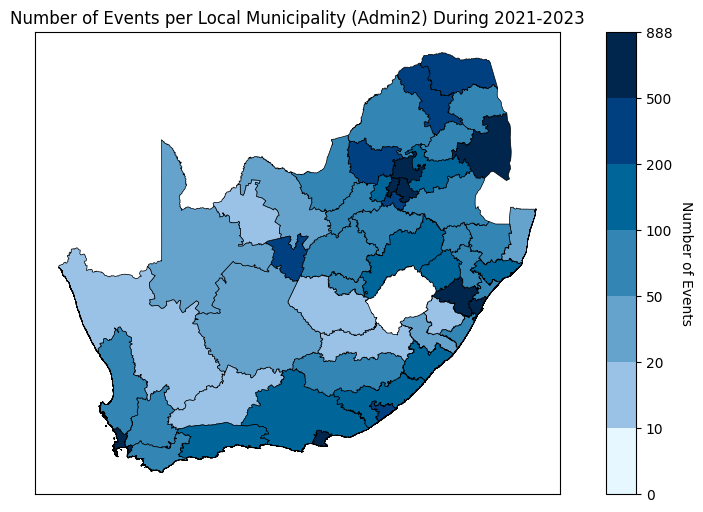

In [88]:
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip install mapclassify

# define bins
bins = [0, 10, 20, 50, 100, 200, 500, 888]

# create a custom colormap with distinct colors for each bin
colors = ['#E6F7FF', '#99C2E6', '#66A3CC', '#3385B3', '#006699', '#004080', '#00264D']
cmap = ListedColormap(colors)

# plot the choropleth map with user-defined bins
ax = map.plot(
    column='event_id_cnty',
    cmap=cmap,
    legend=False,
    edgecolor='k',
    linewidth=0.5,
    scheme='user_defined',
    classification_kwds={'bins': bins},
    figsize=(10, 6)
)

# remove axis numbers
ax.set_xticks([])
ax.set_yticks([])

# add a title
plt.title('Number of Events per Local Municipality (Admin2) During 2021-2023')

# create a custom legend with a scale-like representation
norm = BoundaryNorm(boundaries=bins, ncolors=len(bins)-1, clip=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # some dummy array for the colormap

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax, ticks=bins, format="%d")

# set colorbar labels and position
cbar.set_label('Number of Events', rotation=270, labelpad=15)

# show the plot
plt.show()

In [89]:
# group by admin2 and calculate the count and list of unique population values
result = merged_df.groupby('admin2').agg({'event_id_cnty': 'count', 'population_2022': 'first'}).reset_index()

# rename the columns for clarity
result.columns = ['admin2', 'event_count', 'population']

# sort the result in descending order by event count
result = result.sort_values(by='event_count', ascending=False)

# display the result
result.head(10)

,admin2,event_count,population
9,City of Cape Town,888,4772846
10,City of Johannesburg,698,4803262
50,eThekwini,606,4239901
11,City of Tshwane,558,4040315
26,Nelson Mandela Bay,328,1190496
38,Umgungundlovu,318,1235715
16,Ekurhuleni,257,4066691
15,Ehlanzeni,239,2270897
33,Sedibeng,161,1190688
18,Frances Baard,152,434343


Cape Town, Johannesburg and Durban (eThekwini) are the 3 largest cities in South Africa and have a correspondingly high prevalence of political disorder events.

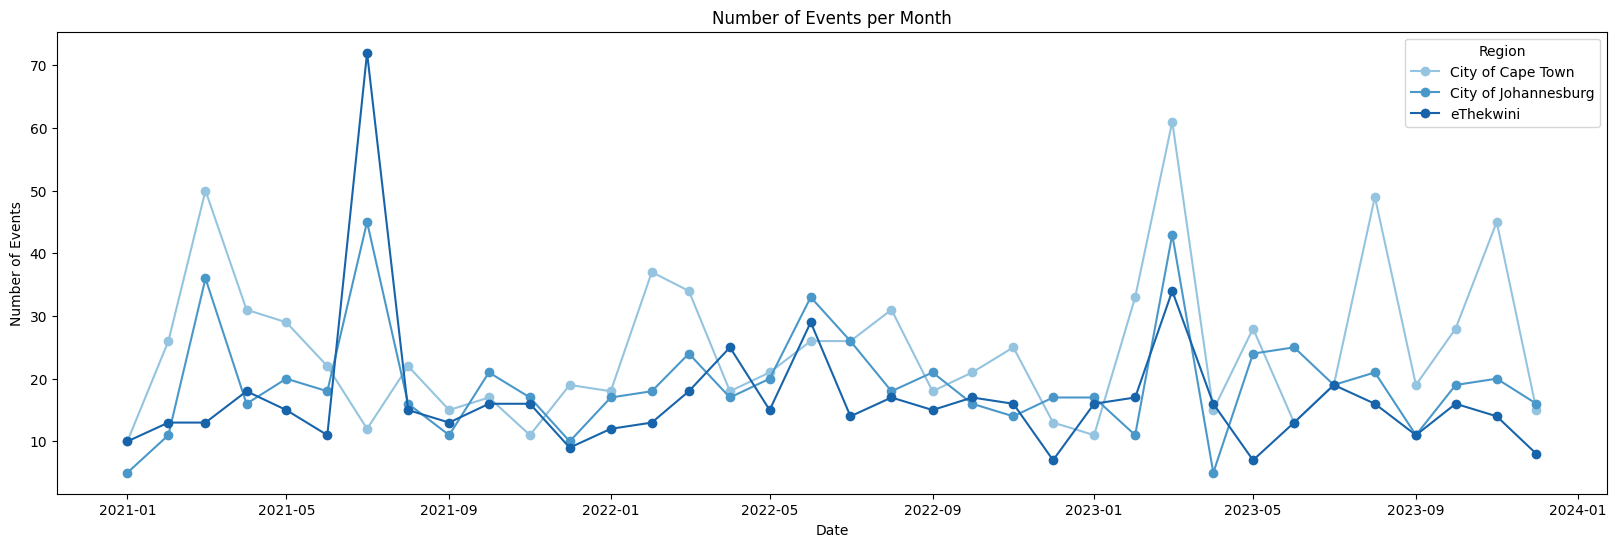

In [96]:
# filter dataset for specified admin2 regions
admin2_regions = ["City of Cape Town", "City of Johannesburg", "eThekwini"]
filtered_df = merged_df[merged_df['admin2'].isin(admin2_regions)]

# convert 'event_date' to datetime format
filtered_df['event_date'] = pd.to_datetime(filtered_df['event_date'])

# group data by 'admin2' and 'event_date' to count events per month
grouped_df = filtered_df.groupby(['admin2', pd.Grouper(key='event_date', freq='MS')]).size().reset_index(name='event_count')

# define a custom colormap with darker shades of 'Blues'
blues_colors = plt.cm.Blues(np.linspace(0.4, 1, 10))
blues_cmap = LinearSegmentedColormap.from_list('Blues_darker', blues_colors)

# plot the results with same formatting
plt.figure(figsize=(20, 6))
for i, region in enumerate(admin2_regions):
    region_data = grouped_df[grouped_df['admin2'] == region]
    plt.plot(region_data['event_date'], region_data['event_count'], label=region, color=blues_cmap(i/len(admin2_regions)), marker='o', linestyle='-')

plt.title('Number of Events per Month')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend(title='Region')

# show the plot
plt.show()

Looking at monthly events for Durban, Johannesburg and eThewini over the three year period we can see that during the July 2021 riots Cape Town was largely unaffected. Let's look at the sub-event breakdown of events per city.

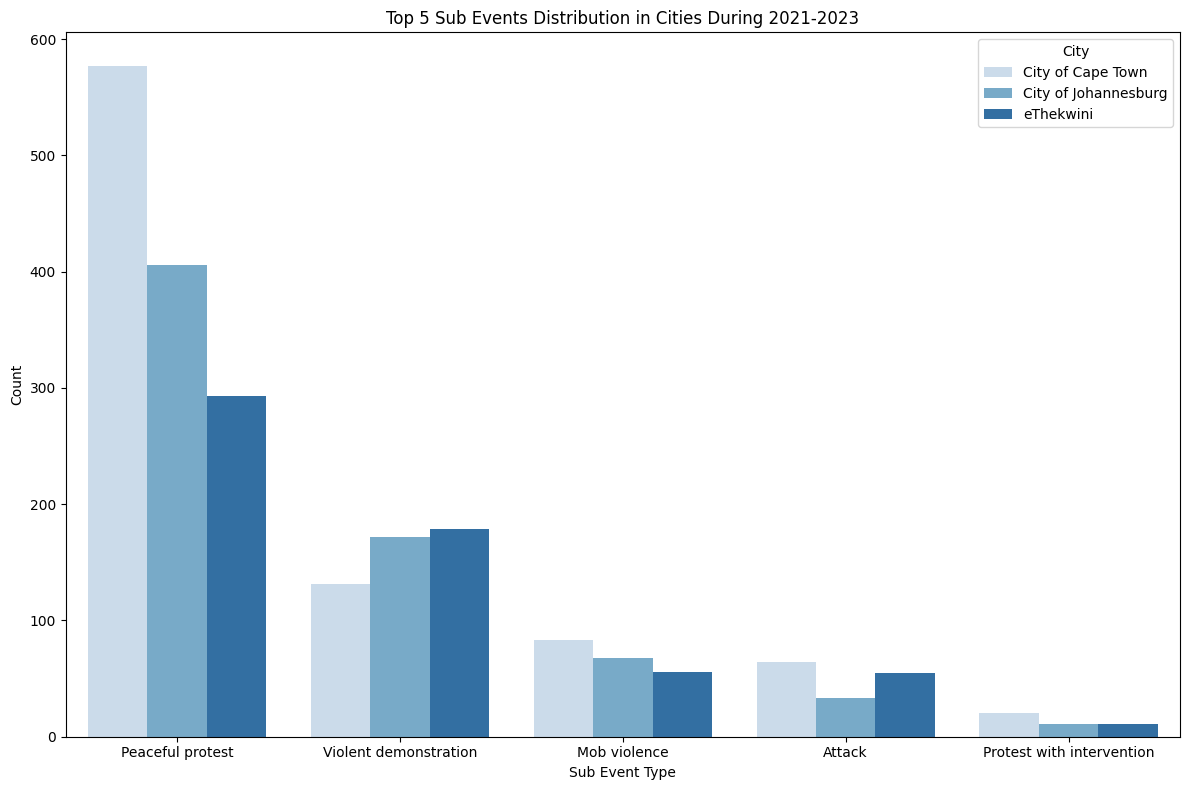

In [91]:
# filter the dataset for the three cities: City of Johannesburg, City of Cape Town, and eThekwini
relevant_cities = ['City of Johannesburg', 'City of Cape Town', 'eThekwini']
filtered_df = merged_df[merged_df['admin2'].isin(relevant_cities)]

# group by admin2 and sub_event_type, then count the occurrences
grouped_df = filtered_df.groupby(['admin2', 'sub_event_type']).size().reset_index(name='count')

# sort the grouped dataframe by count in descending order
grouped_df_sorted = grouped_df.sort_values(by=['count'], ascending=False)

# get unique sub-event types from the dataset
unique_sub_event_types = grouped_df_sorted['sub_event_type'].unique()

# filter to include only the top 5 sub-events
top_5_sub_events = grouped_df_sorted.groupby('sub_event_type').sum().nlargest(5, 'count').index
top_5_grouped_df = grouped_df_sorted[grouped_df_sorted['sub_event_type'].isin(top_5_sub_events)]

# plot grouped bar chart for top 5 sub-events
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_grouped_df, x='sub_event_type', y='count', hue='admin2', palette='Blues')
plt.title('Top 5 Sub Events Distribution in Cities During 2021-2023')
plt.xlabel('Sub Event Type')
plt.ylabel('Count')
plt.legend(title='City')
plt.tight_layout()
plt.show()

When considering the total number of major violent political disorder events (violent demonstrations, mob violence, attack and protests with interventions) over the three-year period, Cape Town's situation is comparable to both Johannesburg and eThekwini.